In [43]:
! pip install scikit-survival lifelines

In [44]:
from lifelines import WeibullFitter, CoxPHFitter, WeibullAFTFitter
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
from lifelines.datasets import load_rossi

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

import numpy as np
import pandas as pd

from lifelines.fitters import ParametricUnivariateFitter
import autograd.numpy as np
from autograd.scipy.stats import norm
from autograd.scipy.special import expit, logit

from matplotlib import pyplot as plt

In [45]:
rossi = load_rossi()

[Rossi Recidivism Dataset](https://rdrr.io/cran/RcmdrPlugin.survival/man/Rossi.html)

In [46]:
rossi.head(5)

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [47]:
T, E = rossi.week, rossi.arrest

# Basic nonparametrics analysis

## Using Kaplan-Meier Estimator

In [48]:
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 432 total observations, 318 right-censored observations>

Text(0.5, 1.0, 'Time to Repeated Crime')

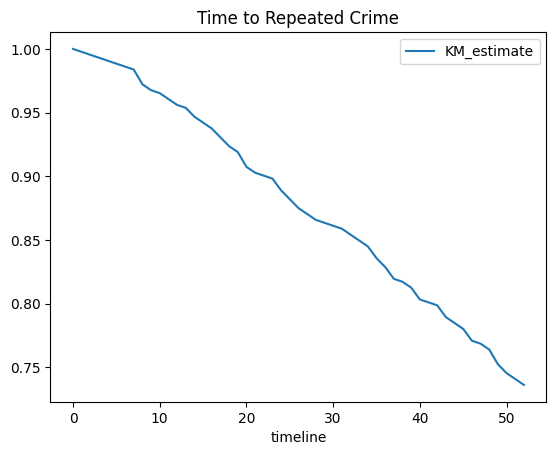

In [49]:
kmf.survival_function_.plot()
plt.title('Time to Repeated Crime')

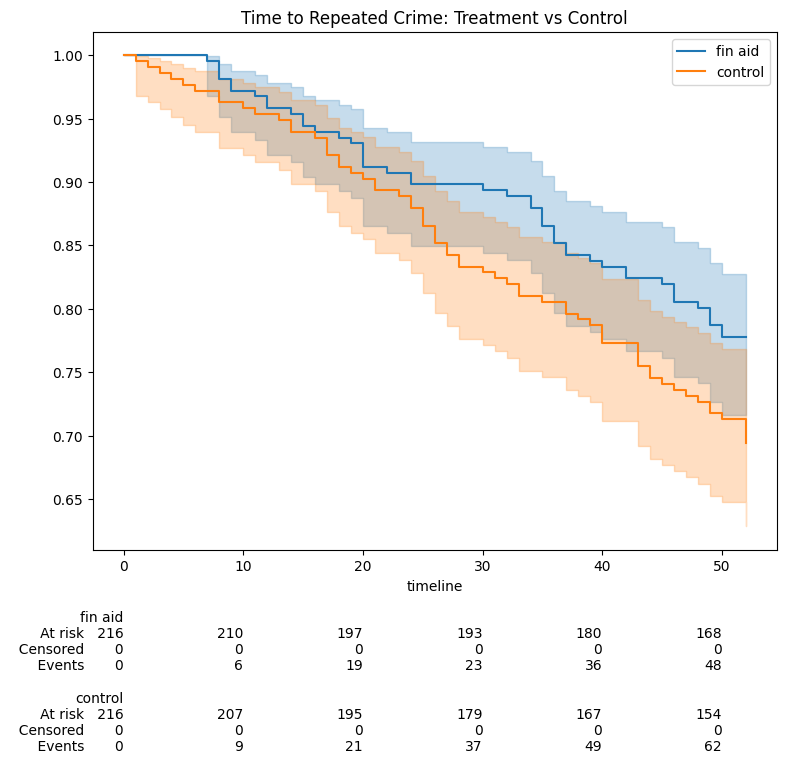

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))

fin_aid = rossi.fin == 1

kmf_aid = KaplanMeierFitter()
ax = kmf_aid.fit(
    T[fin_aid], event_observed=E[fin_aid], label='fin aid'
    ).plot_survival_function(ax=ax)

kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(
    T[~fin_aid], event_observed=E[~fin_aid], label='control'
    ).plot_survival_function(ax=ax)

plt.title('Time to Repeated Crime: Treatment vs Control')
add_at_risk_counts(kmf_aid, kmf_control, ax=ax)
plt.tight_layout()


### logrank test

In [51]:
results = logrank_test(T[fin_aid], T[~fin_aid], E[fin_aid], E[~fin_aid], alpha=.95)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           3.84 0.05      4.32

## Estimating hazard rates using Nelson-Aalen

In [52]:
naf = NelsonAalenFitter()
naf.fit(T,event_observed=E)

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 432 total observations, 318 right-censored observations>

          NA_estimate
timeline             
0.0          0.000000
1.0          0.002315
2.0          0.004635
3.0          0.006961
4.0          0.009292


<Axes: xlabel='timeline'>

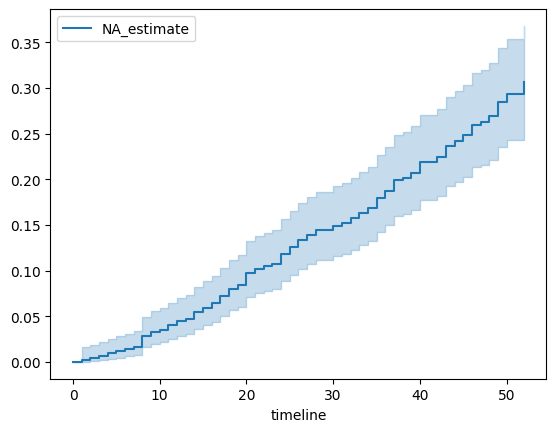

In [53]:
print(naf.cumulative_hazard_.head())
naf.plot_cumulative_hazard()

Text(0.5, 1.0, 'Repeated Crime: Cumulative Hazards')

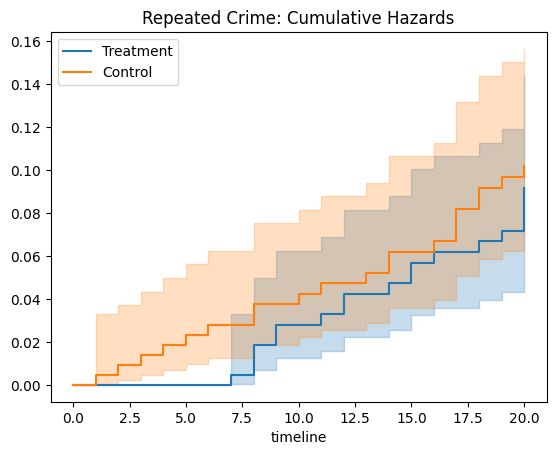

In [54]:
naf.fit(T[fin_aid], event_observed=E[fin_aid], label="Treatment")
ax = naf.plot_cumulative_hazard(loc=slice(0, 20))

naf.fit(T[~fin_aid], event_observed=E[~fin_aid], label="Control")
naf.plot_cumulative_hazard(ax=ax, loc=slice(0, 20))

plt.title("Repeated Crime: Cumulative Hazards")

# Univariate Parametric Models

## Weibull model

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 432 total observations, 318 right-censored observations>
   number of observations = 432
number of events observed = 114
           log-likelihood = -696.62
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 123.68     13.34           97.53          149.83
rho_      1.37      0.12            1.12            1.61

         cmp to    z      p  -log2(p)
lambda_    1.00 9.19 <0.005     64.53
rho_       1.00 2.96 <0.005      8.36
---
AIC = 1397.25

Text(0.5, 1.0, 'Cumulative hazard of Weibull model')

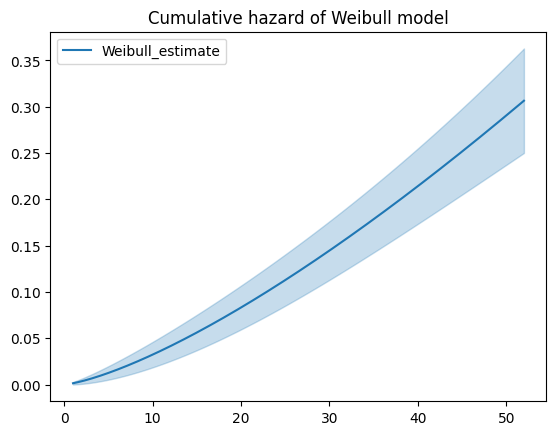

In [55]:
wf = WeibullFitter().fit(T, E)

wf.print_summary()
ax = wf.plot_cumulative_hazard()
ax.set_title("Cumulative hazard of Weibull model")

Text(0.5, 1.0, 'Survival function of Weibull model')

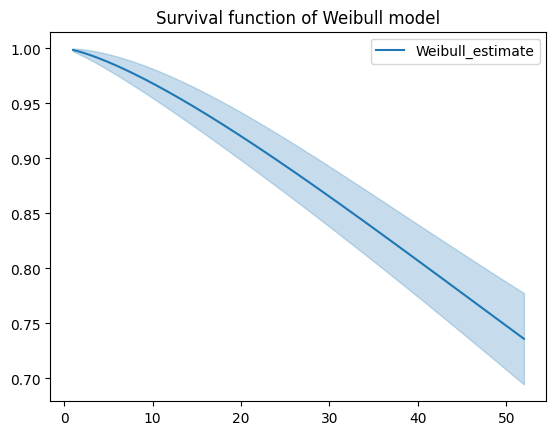

In [16]:
ax = wf.plot_survival_function()
ax.set_title("Survival function of Weibull model")

# Semiparametrics Models

## Cox’s proportional hazard model

In [56]:
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2025-04-27 10:02:35 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.38      0.68      0.19           -0.75           -0.00                0.47                1.00
age       -0.06      0.94      0.02           -0.10           -0.01                0.90                0.99
race       0.31      1.37      0.31           -0.29            0.92                0.75                2.50
wexp      -0.15      0.86      0.21           -0.57            0.27                0.57                1.30
mar       -0.43      0.65      0.38           -1.18            0.31                0.31                1.37
paro      -0.08      0.92      0.20           -0.47            0.30                0.63                1.35
prio       0.09      1.10      0.03            0.04            0.15                1.04                1.16

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

## with penalties

In [57]:
cph = CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
cph.fit(rossi, 'week', 'arrest')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                penalizer = 0.1
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -675.38
         time fit was run = 2025-04-27 10:03:58 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
age       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
race       0.00      1.00      0.00           -0.00            0.00                1.00                1.00
wexp      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
mar       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
paro      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
prio       0.00      1.00      0.00           -0.00            0.00                1.00                1.00

           cmp to     z    p  -log2(p)
covariate                             
fin          0.00 -0.00 1.00      0.00
age          0.00 -0.00 1.00      0.00
race         0.00  0.00 1.00      0.00
wexp         0.00 -0.00 1.00      0.00
mar          0.00 -0.00 1.00      0.00
paro         0.00 -0.00 1.00      0.00
prio         0.00  0.00 1.00      0.00
---
Concordance = 0.64
Partial AIC = 1364.76
log-likelihood ratio test = -0.00 on 7 df
-log2(p) of ll-ratio test = -0.00

In [58]:
penalty = np.array([0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

cph = CoxPHFitter(penalizer=penalty)
cph.fit(rossi, 'week', 'arrest')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                penalizer = [0.  0.5 0.5 0.5 0.5 0.5 0.5]
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -667.42
         time fit was run = 2025-04-27 10:04:15 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.38      0.69      0.19           -0.75           -0.00                0.47                1.00
age       -0.02      0.98      0.01           -0.03            0.00                0.97                1.00
race       0.09      1.10      0.17           -0.23            0.42                0.79                1.53
wexp      -0.15      0.86      0.11           -0.37            0.07                0.69                1.07
mar       -0.17      0.84      0.17           -0.51            0.17                0.60                1.18
paro      -0.04      0.96      0.11           -0.26            0.19                0.77                1.20
prio       0.04      1.04      0.02            0.00            0.07                1.00                1.08

           cmp to     z    p  -log2(p)
covariate                             
fin          0.00 -1.97 0.05      4.37
age          0.00 -1.75 0.08      3.64
race         0.00  0.56 0.57      0.80
wexp         0.00 -1.34 0.18      2.47
mar          0.00 -0.98 0.33      1.61
paro         0.00 -0.32 0.75      0.42
prio         0.00  2.00 0.05      4.45
---
Concordance = 0.63
Partial AIC = 1348.85
log-likelihood ratio test = 15.91 on 7 df
-log2(p) of ll-ratio test = 5.27

## Plotting the effect of varying a covariate

<Axes: >

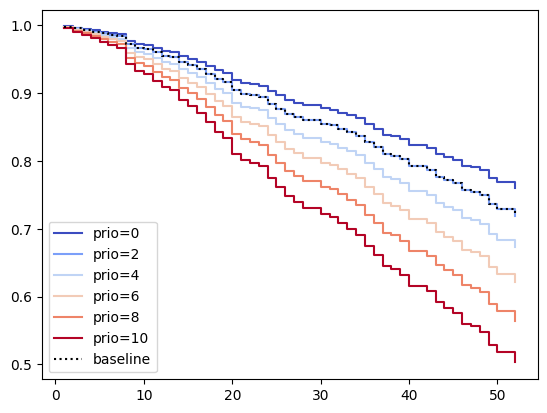

In [20]:
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest')

cph.plot_partial_effects_on_outcome(covariates='prio', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')

# Parametric survival models

## The Weibull AFT model

In [21]:
aft = WeibullAFTFitter()
aft.fit(rossi, duration_col='week', event_col='arrest')

aft.print_summary(3)

<lifelines.WeibullAFTFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
   number of observations = 432
number of events observed = 114
           log-likelihood = -679.917
         time fit was run = 2025-04-27 07:48:47 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                   
lambda_ age        0.041     1.042     0.016           0.009           0.072               1.009               1.075
        fin        0.272     1.313     0.138           0.002           0.543               1.002               1.720
        mar        0.311     1.365     0.273          -0.224           0.847               0.799               2.332
        paro       0.059     1.061     0.140          -0.215           0.333               0.807               1.394
        prio      -0.066     0.936     0.021          -0.107          -0.025               0.899               0.976
        race      -0.225     0.799     0.220          -0.656           0.207               0.519               1.230
        wexp       0.107     1.112     0.152          -0.190           0.404               0.827               1.497
        Intercept  3.990    54.062     0.419           3.169           4.812              23.777             122.921
rho_    Intercept  0.339     1.404     0.089           0.165           0.514               1.179               1.671

                   cmp to      z       p  -log2(p)
param   covariate                                 
lambda_ age         0.000  2.544   0.011     6.512
        fin         0.000  1.973   0.049     4.365
        mar         0.000  1.139   0.255     1.973
        paro        0.000  0.421   0.674     0.570
        prio        0.000 -3.143   0.002     9.224
        race        0.000 -1.021   0.307     1.703
        wexp        0.000  0.703   0.482     1.053
        Intercept   0.000  9.521 <0.0005    68.978
rho_    Intercept   0.000  3.809 <0.0005    12.807
---
Concordance = 0.640
AIC = 1377.833
log-likelihood ratio test = 33.416 on 7 df
-log2(p) of ll-ratio test = 15.462

In [22]:
print(aft.median_survival_time_)
print(aft.mean_survival_time_)

87.7410313326126
103.78671283934625


### With ancillary parameters

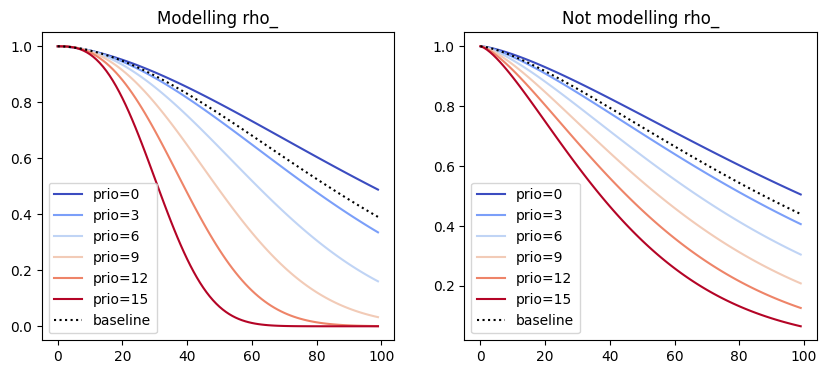

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

times = np.arange(0, 100)
wft_model_rho = WeibullAFTFitter().fit(rossi, 'week', 'arrest', ancillary=True, timeline=times)
wft_model_rho.plot_partial_effects_on_outcome('prio', range(0, 16, 3), cmap='coolwarm', ax=ax[0])
ax[0].set_title("Modelling rho_")

wft_not_model_rho = WeibullAFTFitter().fit(rossi, 'week', 'arrest', ancillary=False, timeline=times)
wft_not_model_rho.plot_partial_effects_on_outcome('prio', range(0, 16, 3), cmap='coolwarm', ax=ax[1])
ax[1].set_title("Not modelling rho_");

# Random Survival Forest

In [24]:
random_state=42

In [25]:
dt = [('cens', '?'), ('time', '<f8')]
y = np.asarray(list(zip(E.astype(bool), T.astype(float))), dtype=dt)
X = rossi.iloc[:, 2:].copy()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

In [27]:
y[:10]

array([( True, 20.), ( True, 17.), ( True, 25.), (False, 52.),
       (False, 52.), (False, 52.), ( True, 23.), (False, 52.),
       (False, 52.), (False, 52.)], dtype=[('cens', '?'), ('time', '<f8')])

In [28]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=6, min_samples_leaf=10, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=10, n_estimators=1000, n_jobs=-1,
                     random_state=42)

In [29]:
rsf.score(X_test, y_test)

np.float64(0.635301968635302)

In [30]:
X_test_sorted = X_test.sort_values(by=["prio", "age"])
X_test_sel = pd.concat((X_test_sorted.head(10), X_test_sorted.tail(10)))

In [31]:
pd.Series(rsf.predict(X_test_sel))[:10].mean()

np.float64(6.234065859590336)

In [32]:
pd.Series(rsf.predict(X_test_sel))[10:].mean()

np.float64(8.471156308516658)

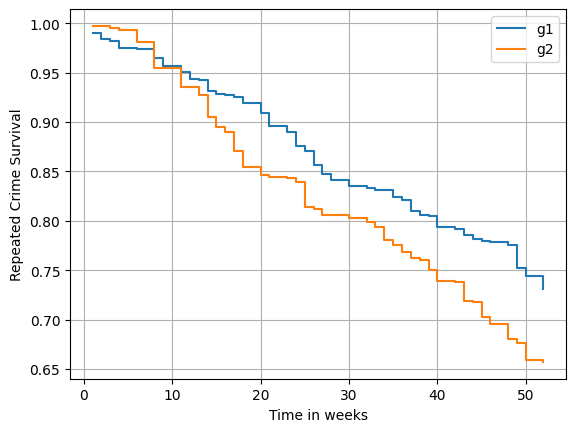

In [33]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

g1, g2 = surv[:10, :].mean(axis=0), surv[10:, :].mean(axis=0)

plt.step(rsf.unique_times_, g1, where='post', label='g1')
plt.step(rsf.unique_times_, g2, where='post', label='g2')

plt.ylabel("Repeated Crime Survival")
plt.xlabel("Time in weeks")
plt.legend()
plt.grid(True)

## Permutation-based Feature Importance

In [34]:
result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)

In [35]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
age,0.055322,0.027307
wexp,0.035647,0.012797
prio,0.033344,0.021043
mar,0.009198,0.011745
paro,0.001201,0.011240
race,0.000968,0.004252
fin,-0.019308,0.028658


# Cure Models

In [36]:
N = 1000
U = np.random.rand(N)
T = -(logit(-np.log(U) / 0.5) - np.random.exponential(2, N) - 6.00) / 0.50

E = ~np.isnan(T)
T[np.isnan(T)] = 50

<Axes: xlabel='timeline'>

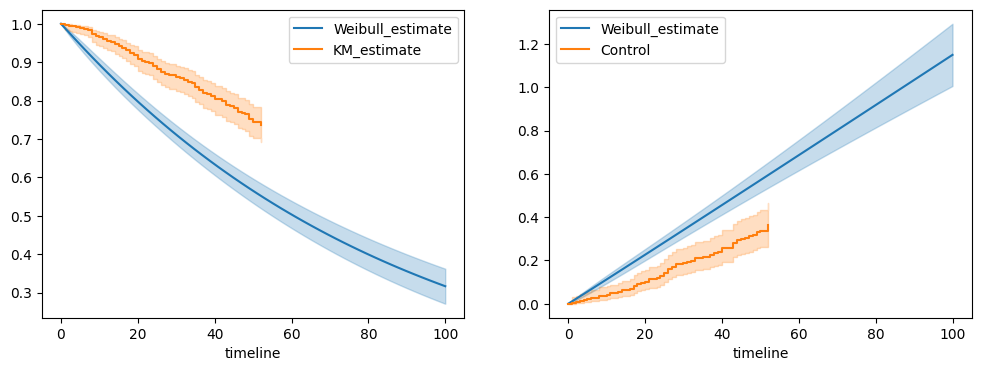

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

t = np.linspace(0, 40)
llf = WeibullFitter().fit(T, E, timeline=t)

t = np.linspace(0, 100)
llf = WeibullFitter().fit(T, E, timeline=t)

llf.plot_survival_function(ax=ax[0])
kmf.plot(ax=ax[0])

llf.plot_cumulative_hazard(ax=ax[1])
naf.plot(ax=ax[1])

Text(0.5, 1.0, 'Survival function estimated by KaplanMeier')

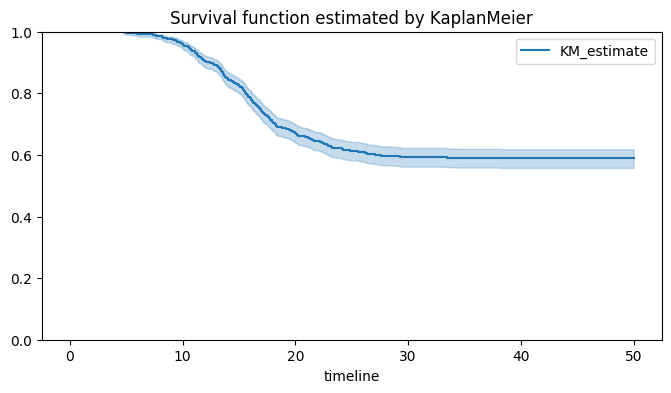

In [38]:
kmf = KaplanMeierFitter().fit(T, E)
kmf.plot(figsize=(8,4))
plt.ylim(0, 1);
plt.title("Survival function estimated by KaplanMeier")

Text(0.5, 1.0, 'Cumulative hazard estimated by NelsonAalen')

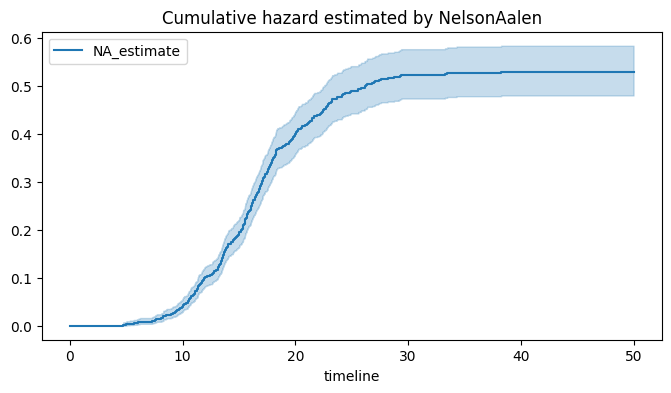

In [39]:
naf = NelsonAalenFitter().fit(T, E)
naf.plot(figsize=(8,4))
plt.title("Cumulative hazard estimated by NelsonAalen")

In [40]:
class UpperAsymptoteFitter(ParametricUnivariateFitter):

    _fitted_parameter_names = ["c_", "mu_", "sigma_"]

    _bounds = ((0, None), (None, None), (0, None))

    def _cumulative_hazard(self, params, times):
        c, mu, sigma = params
        return c * norm.cdf((times - mu) / sigma, loc=0, scale=1)

<lifelines.UpperAsymptoteFitter:"UpperAsymptote_estimate", fitted with 1000 total observations, 589 right-censored observations>
   number of observations = 1000
number of events observed = 411
           log-likelihood = -1934.605
               hypothesis = c_ != 1, mu_ != 0, sigma_ != 1

---
         coef  se(coef)  coef lower 95%  coef upper 95%
c_      0.533     0.027           0.481           0.586
mu_    16.885     0.259          16.377          17.393
sigma_  5.194     0.181           4.839           5.550

        cmp to       z       p  -log2(p)
c_       1.000 -17.537 <0.0005   226.312
mu_      0.000  65.151 <0.0005       inf
sigma_   1.000  23.128 <0.0005   390.718
---
AIC = 3875.211

<Axes: >

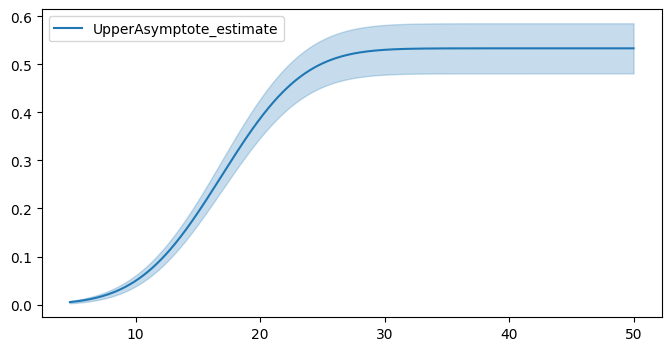

In [41]:
uaf = UpperAsymptoteFitter().fit(T, E)
uaf.print_summary(3)
uaf.plot(figsize=(8,4))

<Axes: xlabel='timeline'>

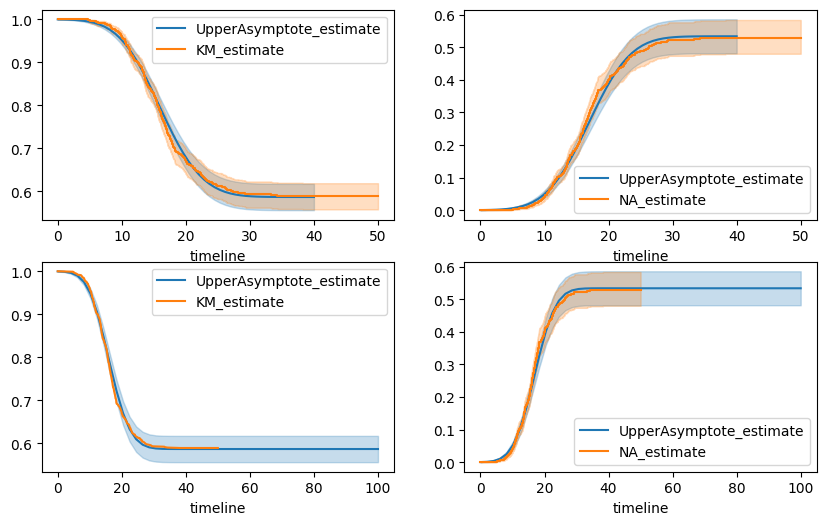

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

t = np.linspace(0, 40)
uaf = UpperAsymptoteFitter().fit(T, E, timeline=t)

uaf.plot_survival_function(ax=ax[0][0])
kmf.plot(ax=ax[0][0])

uaf.plot_cumulative_hazard(ax=ax[0][1])
naf.plot(ax=ax[0][1])

t = np.linspace(0, 100)
uaf = UpperAsymptoteFitter().fit(T, E, timeline=t)
uaf.plot_survival_function(ax=ax[1][0])
kmf.survival_function_.plot(ax=ax[1][0])

uaf.plot_cumulative_hazard(ax=ax[1][1])
naf.plot(ax=ax[1][1])

<Axes: xlabel='event_at'>

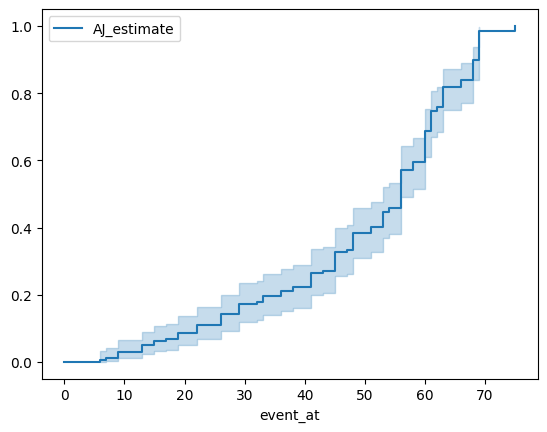

In [ ]:
from lifelines import AalenJohansenFitter
from lifelines.datasets import load_waltons
T, E = load_waltons()['T'], load_waltons()['E']
ajf = AalenJohansenFitter(calculate_variance=True)
ajf.fit(T, E, event_of_interest=1)
ajf.cumulative_density_
ajf.plot()